This is a demo illustrating an application of the OS2D method on one image.
Demo assumes the OS2D code is [installed](./INSTALL.md).

In [1]:
import os
import argparse
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
from os2d.modeling.model import build_os2d_from_config
from os2d.config import cfg
from os2d.structures.bounding_box import cat_boxlist, BoxList, boxlist_iou
import  os2d.utils.visualization as visualizer
from os2d.structures.feature_map import FeatureMapSize
from os2d.utils import setup_logger, read_image, get_image_size_after_resize_preserving_aspect_ratio

logger = setup_logger("OS2D")

In [2]:
def filtered_bboxes(boxes, labels, scores, score_threshold=0.0, max_dets=None):
    good_ids = torch.nonzero(scores.float() > score_threshold).view(-1)
    if good_ids.numel() > 0:
        if max_dets is not None:
                _, ids = scores[good_ids].sort(descending=True)
                good_ids = good_ids[ids[-max_dets:]]
                # print(good_ids)
        boxes = boxes[good_ids].cpu()
        labels = labels[good_ids].cpu()
        scores = scores[good_ids].cpu()
        label_names = [ "Cl "+ str(l.item()) for l in labels]
        box_colors = ["yellow"] * len(boxes)
    else:
        boxes = BoxList.create_empty(boxes.image_size)
        labels = torch.LongTensor(0)
        scores = torch.FloatTensor(0)
        label_names = []
        box_colors = []
    # boxes = boxes.bbox_xyxy
    return boxes

In [3]:
# use GPU if have available
cfg.is_cuda = torch.cuda.is_available()

Download the trained model (is the script does not work download from [Google Drive](https://drive.google.com/open?id=1l_aanrxHj14d_QkCpein8wFmainNAzo8) and put to models/os2d_v2-train.pth). See [README](./README.md) to get links for other released models.

In [4]:
cfg.init.model = "models/os2d_v2-train.pth"
net, box_coder, criterion, img_normalization, optimizer_state = build_os2d_from_config(cfg)
net.eval()

2021-10-08 09:35:21,046 OS2D INFO: Building the OS2D model
2021-10-08 09:35:21,335 OS2D INFO: Creating model on CPU
2021-10-08 09:35:21,336 OS2D INFO: Reading model file models/os2d_v2-train.pth
2021-10-08 09:35:21,408 OS2D INFO: Loaded complete model from checkpoint
2021-10-08 09:35:21,408 OS2D INFO: Cannot find 'optimizer' in the checkpoint file. Initializing optimizer from scratch.
2021-10-08 09:35:21,414 OS2D INFO: OS2D has 139 blocks of 10169478 parameters (before freezing)
2021-10-08 09:35:21,415 OS2D INFO: OS2D has 139 blocks of 10169478 trainable parameters


Get the image where to detect and two class images.

In [5]:
classes=os.listdir('data/demo/classes')
imgs=[]
for i in classes:
    if i[-4:]=='.jpg':
        imgs.append(i)
print(imgs)

['wxqpbtwqps.jpg', 'yqslkmjwsdqps.jpg', 'sodazyqtqps.jpg', 'yrsmtwyl.jpg', 'sodathytqps.jpg', 'wxqpmywqps.jpg', 'qpsbptwyl.jpg', 'yqslkmjwsdqpsA.jpg', 'qqdqtwsdqps.jpg', 'nfsqrxxjwsdqps.jpg', 'ksnmwsdqps.jpg', 'yqslbtwsdqpsA.jpg', 'yqdxywsdqps.jpg', 'ksllwsdqps.jpg', 'yqslrsjwsdqps.jpg', 'wxqpbxgwqps.jpg', 'xcblbxgrsjwwtqps.jpg', 'qnsnmwyl.jpg', 'HPhppnmfwqps.jpg', 'qtssmtwyl.jpg', 'AHyzhywqps.jpg', 'xchyyzwwtqps.jpg', 'xcgsbtwwtqps.jpg', 'sodakmjxrzqps.jpg', 'jqdjjwsdqps.jpg', 'HPhppsmtfwqps.jpg', 'nfsqmjtwsdqps.jpg', 'yqslxhptwsdqps.jpg', 'yqslbtwsdqps.jpg', 'yrnrwyl.jpg', 'nfsqcjygwsdqps.jpg', 'kkkltwyl.jpg', 'lqdlzwsdqps.jpg', 'sqbbbtwqps.jpg', 'xchylzwwtqps.jpg', 'AHbtwlcwqps.jpg', '4.jpg', 'tyAHpgcfjyl.jpg', 'ksbtwsdqps.jpg', 'xcjfptwwtqps.jpg', 'tyAHnmwfjyl.jpg', '2.jpg', 'sqbbxgwqps.jpg', 'tqdbtwsdqps.jpg', '3.jpg', '1.jpg', 'yqslsmzsdqps.jpg', 'nfsqfxbtwsdqps.jpg']


In [6]:
input_image = read_image("data/demo/5.jpg")
# img =  np.array(input_image)
# img = img.transpose(1, 0, 2)
# img=img[:,::-1,:]
# img=Image.fromarray(img.astype('uint8')).convert('RGB')
# img.save("data/demo/4.jpg", quality=100)
# class_images = [read_image("data/demo/class_image_0.jpg"),
#                 read_image("data/demo/class_image_1.jpg")]
class_images = [read_image("data/demo/classes/{}".format(imgs[i])) for i in range(len(imgs))]
class_ids = list(range(len(imgs)))

Use torchvision to convert images to torch.Tensor and to apply normalization.

In [7]:
transform_image = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(img_normalization["mean"], img_normalization["std"])
                      ])

Prepare the input image

In [8]:
h, w = get_image_size_after_resize_preserving_aspect_ratio(h=input_image.size[1],
                                                               w=input_image.size[0],
                                                               target_size=4040)
input_image = input_image.resize((w, h))

input_image_th = transform_image(input_image)
input_image_th = input_image_th.unsqueeze(0)
if cfg.is_cuda:
    input_image_th = input_image_th.cuda()
print(w, h)

3498 4664


Prepare the class images

In [9]:
class_images_th = []
for class_image in class_images:
    h, w = get_image_size_after_resize_preserving_aspect_ratio(h=class_image.size[1],
                                                               w=class_image.size[0],
                                                               target_size=cfg.model.class_image_size)
    class_image = class_image.resize((w, h))

    class_image_th = transform_image(class_image)
    if cfg.is_cuda:
        class_image_th = class_image_th.cuda()

    class_images_th.append(class_image_th)
    # print(h,w)
print(cfg.model.class_image_size)

240


Run the network with one command

In [10]:
@torch.no_grad()
def inference(class_images_th,input_image_th,net):
    loc_prediction=[]
    class_prediction=[]
    class_conv_layer_batched=[]
    transform_corners=[]
    for i in range(len(class_images_th)):
        class_feature_maps = net.net_label_features([class_images_th[i]])
        class_head=net.os2d_head_creator.create_os2d_head(class_feature_maps)
        class_conv_layer_batched.append(class_head)
    feature_map = net.net_feature_maps(input_image_th)
    for i in range(len(class_conv_layer_batched)):
        loc_prediction_batch, class_prediction_batch, _, fm_size, transform_corners_batch = net(feature_maps=feature_map, class_head=class_conv_layer_batched[i])
        loc_prediction.append(loc_prediction_batch[0])
        class_prediction.append(class_prediction_batch[0])
        transform_corners.append(transform_corners_batch[0])
    return torch.cat(loc_prediction,dim=0),torch.cat(class_prediction,dim=0),torch.cat(transform_corners,dim=0)
loc_prediction,class_prediction,transform_corners=inference(class_images_th,input_image_th,net)
image_loc_scores_pyramid = [loc_prediction]
image_class_scores_pyramid = [class_prediction]
img_size_pyramid = [FeatureMapSize(img=input_image_th)]
transform_corners_pyramid = [transform_corners]

Alternatively one can run the stages of the model separatly, which is convenient, e.g., for sharing class feature extraction between many input images.

Convert image organized in batches into images organized in pyramid levels. Not needed in the demo, but essential for multiple images in a batch and multiple pyramid levels.

Decode network outputs into detection boxes

In [11]:
boxes = box_coder.decode_pyramid(image_loc_scores_pyramid, image_class_scores_pyramid,
                                           img_size_pyramid, class_ids,
                                           nms_iou_threshold=cfg.eval.nms_iou_threshold,
                                           nms_score_threshold=cfg.eval.nms_score_threshold,
                                           transform_corners_pyramid=transform_corners_pyramid)

# remove some fields to lighten visualization                                       
boxes.remove_field("default_boxes")


In [12]:
# Note that the system outputs the correaltions that lie in the [-1, 1] segment as the detection scores (the higher the better the detection).
scores = boxes.get_field("scores")
labels=boxes.get_field("labels")
box_xyxy=boxes.bbox_xyxy
print(box_xyxy)

tensor([[1173.8358, 1489.5334, 1360.5477, 2055.0435],
        [1229.1796, 2281.1660, 1400.1107, 2840.0850],
        [2196.6958, 3048.0701, 2345.0840, 3612.3660],
        ...,
        [ 588.7028, 1886.0042,  777.2167, 2650.9797],
        [1848.9429,    0.0000, 2334.6396,  269.3898],
        [2418.4507, 2746.2454, 2772.6851, 3158.3577]])


Show class images

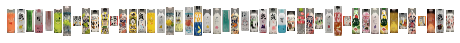

In [13]:
figsize = (8, 16)
fig=plt.figure(figsize=figsize)
columns = len(class_images)
for i, class_image in enumerate(class_images):
    fig.add_subplot(1, columns, i + 1)
    plt.imshow(class_image)
    plt.axis('off')


In [14]:
print(cfg.eval.nms_across_classes)
cfg.eval.nms_across_classes=True

True


Show fixed number of detections that are above a certain threshold. Yellow rectangles show detection boxes. Each box has a class label and the detection scores (the higher the better the detection). Red parallelograms illustrate the affine transformations that align class images to the input image at the location of detection.

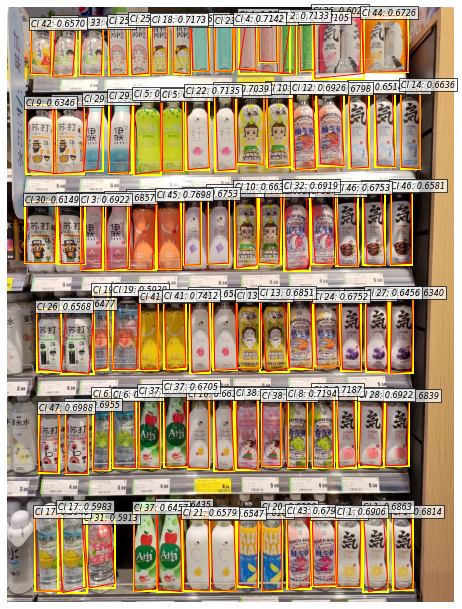

In [15]:
plt.rcParams["figure.figsize"] = figsize

cfg.visualization.eval.max_detections = 100
cfg.visualization.eval.score_threshold = float("0.55")
bbox=visualizer.show_detections(boxes, input_image,
                           cfg.visualization.eval)

torch.Size([90])


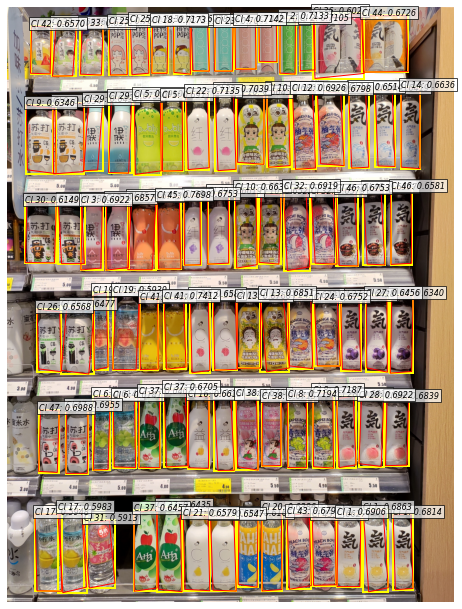

In [22]:
labels = boxes.get_field("labels").clone()
scores = boxes.get_field("scores").clone()
b=filtered_bboxes(boxes,labels, scores, score_threshold=float("0.55"), max_dets=100)
print(b.get_field("labels").shape)
# l=b.get_field("labels").clone()
# s=b.get_field("scores").clone()
iou=boxlist_iou(b,b)
# print(iou)
# print(b.get_field('scores'))
idx=torch.nonzero(torch.sum(iou,dim=0)<1.5).view(-1)
# print(idx)
b = b[idx].cpu()
bbox=visualizer.show_detections(b, input_image,
                           cfg.visualization.eval)


In [42]:
s=np.array(b.get_field('scores').cpu())
l=np.array(b.get_field('labels').cpu())
s=np.expand_dims(s,axis=1)
l=np.expand_dims(l,axis=1)
xyxy=np.array(b.bbox_xyxy.cpu())
res=np.concatenate((l,s,xyxy),axis=1)
print(res[1])
# print(s.shape)


[4.10000000e+01 7.41217673e-01 1.22917957e+03 2.28116602e+03
 1.40011072e+03 2.84008496e+03]
